# GPU implementation of convolutional neural network for a trivial multi-classification problem with Pytorch

In [20]:
# GPU info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Nov  4 09:05:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |   2600MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [21]:
!pip install torchinfo 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
from torch.optim import SGD, Adam
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix, classification_report
from torchinfo import summary

## Upload Dataset

In [23]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
data = np.load('/content/gdrive/My Drive/Xeye_dataset/TrivialMultiClassification.npz')
data.files

['X_train', 'X_test', 'y_train', 'y_test']

In [25]:
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']
# Dataset dimensions (num of images, height, width, num.channel)
print(f'X_train dataset shape: {X_train.shape}')
print(f'X_test dataset shape: {X_test.shape}')
# Labels 
print(y_train.shape)
print(y_test.shape)

X_train dataset shape: (2250, 100, 100, 3)
X_test dataset shape: (750, 100, 100, 3)
(2250,)
(750,)


## Visualize a batch of images from the training dataset

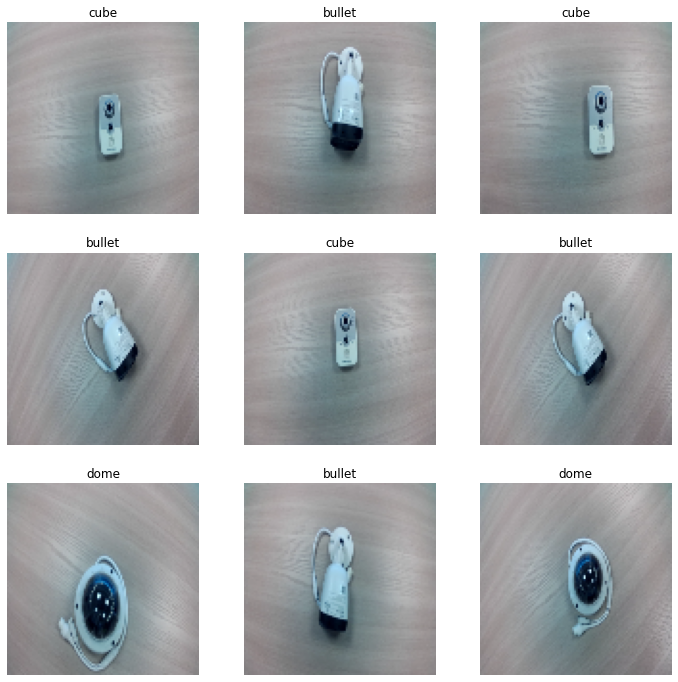

In [26]:
# label list 
label = ['dome', 'bullet', 'cube']
# plot function
def batchView(X, y, n, rows=4, cols=4, fontsize=12):
    plt.figure(figsize=(12,12))
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        img = X_train[n+i]
        plt.imshow(img)
        plt.title(f"{label[y_train[n+i]]}", fontsize=fontsize)
        plt.axis('off')

batchView(X_train, y_train, 10, 3, 3)

## Preprocessing

In [27]:
#Min-max feature scaling = values of single pixel between [0,1] instead of [0 = black , 255 = white]
X_train = X_train / 255
X_test = X_test / 255

## Converting into Torch tensors and select the device (cpu or gpu)

In [29]:
# Conversion 
X_train_t = torch.tensor(X_train).float()
y_train_t = torch.tensor(y_train).long()
# Select available device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# pass the objects into the device selected
X_train_t = X_train_t.to(device)
y_train_t = y_train_t.to(device)
# dimensions
print(f'X_train Torch tensor: {X_train_t.shape}')
print(f'y_train Torch tensor: {y_train_t.shape}')

X_train Torch tensor: torch.Size([2250, 100, 100, 3])
y_train Torch tensor: torch.Size([2250])


## Defining dataset class

In [30]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x = x.view(-1,3,100,100).float()
        self.y = y.clone().detach()
    def __len__(self):
        return len(self.x)
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
# create a MyDataset object 
ds = MyDataset(X_train_t, y_train_t)

## Create the dataloader

In [31]:
batch_size = 256
dl = DataLoader(ds, batch_size=batch_size, shuffle=True)

## Define the network structure (LeNet-5)

In [32]:
def get_model():
  model = nn.Sequential(
      nn.Conv2d(3, 6, kernel_size=5),
      nn.AvgPool2d(2),
      nn.Tanh(),
      nn.Conv2d(6,16, kernel_size=5),
      nn.MaxPool2d(2),
      nn.Tanh(),
      nn.Flatten(),
      nn.Linear(7744,120),
      nn.Tanh(),
      nn.Linear(120,84),
      nn.Tanh(),
      nn.Linear(84,3),
      nn.Softmax(dim=1)
  ).to(device)
  #objective function and upgrade weights method
  loss_func = nn.CrossEntropyLoss()
  opt = Adam(model.parameters(), lr=1e-3)
  
  return model, loss_func, opt

In [33]:
model, loss_func, opt = get_model()
summary(model, input_size=(1, 3, 100, 100))

Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 3]                    --
├─Conv2d: 1-1                            [1, 6, 96, 96]            456
├─AvgPool2d: 1-2                         [1, 6, 48, 48]            --
├─Tanh: 1-3                              [1, 6, 48, 48]            --
├─Conv2d: 1-4                            [1, 16, 44, 44]           2,416
├─MaxPool2d: 1-5                         [1, 16, 22, 22]           --
├─Tanh: 1-6                              [1, 16, 22, 22]           --
├─Flatten: 1-7                           [1, 7744]                 --
├─Linear: 1-8                            [1, 120]                  929,400
├─Tanh: 1-9                              [1, 120]                  --
├─Linear: 1-10                           [1, 84]                   10,164
├─Tanh: 1-11                             [1, 84]                   --
├─Linear: 1-12                           [1, 3]                    255
├

## Define objective function and upgrade weights method

In [34]:
img = X_train_t[1].view(-1,3,100,100)
print(f'1) size of the image: {img.size()}')
print(f'2) label of the image: {y_train_t[1]} = bullet')
print(f'3) value of the output node of the network: {model(img)}')
#print(f'4) predicted class: {np.argmax(model(img))} = mouse') # wrong prediction 

1) size of the image: torch.Size([1, 3, 100, 100])
2) label of the image: 1 = bullet
3) value of the output node of the network: tensor([[0.3263, 0.3218, 0.3519]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


In [35]:
torch.max(model(img))

tensor(0.3519, device='cuda:0', grad_fn=<MaxBackward1>)

In [36]:
pred = model(X_train_t.view(2250,3,100,100))
print(pred)
y_pred_tag = np.argmax(pred.cpu().detach().numpy(), axis = 1)
print(y_pred_tag)
print(y_pred_tag.shape)

tensor([[0.3269, 0.3219, 0.3512],
        [0.3263, 0.3218, 0.3519],
        [0.3273, 0.3206, 0.3522],
        ...,
        [0.3279, 0.3222, 0.3498],
        [0.3284, 0.3216, 0.3500],
        [0.3272, 0.3215, 0.3513]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
[2 2 2 ... 2 2 2]
(2250,)


In [37]:
def accuracy_val(y_pred, y_val):

    y_pred_tag = np.argmax(y_pred.cpu().detach().numpy(), axis = 1)
    y_val = np.array(y_val.cpu().detach())

    correct_results = np.sum(y_pred_tag == y_val)
    acc = correct_results/y_val.shape[0]
    acc = np.round(acc * 100)
    
    return acc

In [38]:
epochs = 3
loss_history = []
acc_history = []
model.train()
print('===========================================================')
for _ in range(epochs):
    numBatch = np.round(X_train_t.shape[0]/batch_size)
    batch = 1
    for data in dl:

        x, y = data
        opt.zero_grad()

        predicted = model(x)
        loss_value = loss_func(predicted, y)
        acc_value = accuracy_val(predicted, y)


        loss_value.backward()
        opt.step()

        loss_history.append(loss_value)
        acc_history.append(acc_value)

        print(f'epoch: {_+1}/{int(epochs)} | batch: {batch}/{int(numBatch)} | loss: {loss_value:.4f} | accuracy: {acc_value}%')

        batch += 1

print('===========================================================')

epoch: 1/3 | batch: 1/9 | loss: 1.0994 | accuracy: 31.0%
epoch: 1/3 | batch: 2/9 | loss: 1.1042 | accuracy: 57.0%
epoch: 1/3 | batch: 3/9 | loss: 1.1082 | accuracy: 33.0%
epoch: 1/3 | batch: 4/9 | loss: 1.0685 | accuracy: 60.0%
epoch: 1/3 | batch: 5/9 | loss: 1.0989 | accuracy: 28.0%
epoch: 1/3 | batch: 6/9 | loss: 1.0739 | accuracy: 53.0%
epoch: 1/3 | batch: 7/9 | loss: 1.0745 | accuracy: 29.0%
epoch: 1/3 | batch: 8/9 | loss: 1.0314 | accuracy: 65.0%
epoch: 1/3 | batch: 9/9 | loss: 1.0163 | accuracy: 49.0%
epoch: 2/3 | batch: 1/9 | loss: 1.0088 | accuracy: 54.0%
epoch: 2/3 | batch: 2/9 | loss: 0.9689 | accuracy: 77.0%
epoch: 2/3 | batch: 3/9 | loss: 0.9390 | accuracy: 90.0%
epoch: 2/3 | batch: 4/9 | loss: 0.9026 | accuracy: 88.0%
epoch: 2/3 | batch: 5/9 | loss: 0.8690 | accuracy: 91.0%
epoch: 2/3 | batch: 6/9 | loss: 0.8521 | accuracy: 89.0%
epoch: 2/3 | batch: 7/9 | loss: 0.8165 | accuracy: 88.0%
epoch: 2/3 | batch: 8/9 | loss: 0.7901 | accuracy: 89.0%
epoch: 2/3 | batch: 9/9 | loss:

## Prediction of a label for a new "virtual" image passed in input to the trained model

(-0.5, 99.5, 99.5, -0.5)

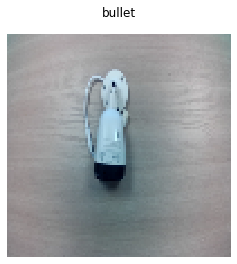

In [39]:
index = 0
plt.matshow(X_test[index])
plt.title(f"{label[y_test[index]]}", fontsize=12)
plt.axis('off')

In [40]:
# Conversion 
X_test_t = torch.tensor(X_test).float()
y_test_t = torch.tensor(y_test).long()
# Select available device 
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# pass the objects into the device selected
X_test_t = X_test_t.to(device)
y_test_t = y_test_t.to(device)

In [47]:
label = ['dome', 'bullet', 'cube']
y_test[0] # label 1 = bullet

1

In [43]:
# predict
img = X_test_t[0].view(-1,3,100,100)
output = model(img)
output

tensor([[0.0023, 0.9886, 0.0091]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [49]:
tag_pred = int(np.argmax(output.cpu().detach().numpy(), axis = 1))
print(tag_pred)
print(label[tag_pred])

1
bullet


## Prediction on Test dataset

In [50]:
X_test_t.shape

torch.Size([750, 100, 100, 3])

In [52]:
X_test_t_res = X_test_t.view(750,3,100,100)
X_test_t_res.shape

torch.Size([750, 3, 100, 100])

In [56]:
pred = model(X_test_t_res)
y_pred_tag = np.argmax(pred.cpu().detach().numpy(), axis = 1)
print(y_pred_tag.shape)
y_val_test = np.array(y_test_t.cpu().detach())
print(y_val_test.shape)

(750,)
(750,)


In [57]:
confusion_matrix(y_val_test, y_pred_tag)

array([[233,  14,   5],
       [ 24, 203,  13],
       [  0,  13, 245]])

In [58]:
print(classification_report(y_val_test, y_pred_tag))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92       252
           1       0.88      0.85      0.86       240
           2       0.93      0.95      0.94       258

    accuracy                           0.91       750
   macro avg       0.91      0.91      0.91       750
weighted avg       0.91      0.91      0.91       750

